In [1]:
import numpy as np 
import pandas as pd
import torchaudio
import torch
from scipy.io.wavfile import read as read_wav
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [2]:
path = "/kaggle/input/cats-vs-dogs-vs-birds-audio-classification/Animals/bird"
bird_array = [x[2] for x in os.walk(path)]
birds_path = [os.path.join(path, i) for i in bird_array[0]]
birds = ['bird'] * len(birds_path)

In [3]:
path = "/kaggle/input/cats-vs-dogs-vs-birds-audio-classification/Animals/cat"
cat_array = [x[2] for x in os.walk(path)]
cats_path = [os.path.join(path, i) for i in cat_array[0]]
cats = ['cat'] * len(cats_path)

In [4]:
path = "/kaggle/input/cats-vs-dogs-vs-birds-audio-classification/Animals/dog"
dog_array = [x[2] for x in os.walk(path)]
dogs_path = [os.path.join(path, i) for i in dog_array[0]]
dogs = ['dog'] * len(dogs_path)

In [5]:
image_labels = dict()
image_labels['images'] = birds_path + cats_path + dogs_path
image_labels['labels'] = birds + cats + dogs

In [6]:
df = pd.DataFrame(image_labels)

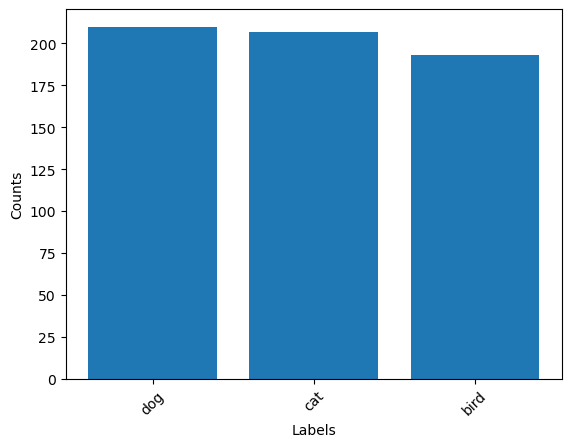

In [7]:
label_counts = df['labels'].value_counts()

plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

In [8]:
temp = df.iloc[0, 0]
rate, data = read_wav(temp)

In [9]:
new_rate = 8000

transform = torchaudio.transforms.Resample(orig_freq=rate, new_freq=new_rate)

In [10]:
label_index = {
    'bird': 0,
    'cat': 1,
    'dog': 2
}

index_label = {
    0: 'bird',
    1: 'cat',
    2: 'dog'
}

In [11]:
df['labels'] = df['labels'].map(label_index)

In [35]:
def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    tensors, labels = [], []
    
    for audio, label in batch:
        au, _ = torchaudio.load(audio)
        au = transform(au)
        tensors += [au]
        labels += [label]
        
    tensors = pad_sequence(tensors)
    labels = torch.tensor(labels, dtype=torch.int64)
    
    return tensors, labels

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE=16
LR=0.1
EPOCHS = 50
tr = df.values
train, val = train_test_split(tr, random_state=42, test_size=0.2)

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AudioCNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AudioCNN, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=80, stride=16)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3)

        # Batch Normalization Layers
        self.batch1 = nn.BatchNorm1d(32)
        self.batch2 = nn.BatchNorm1d(64)
        self.batch3 = nn.BatchNorm1d(128)

        # Max Pooling Layers
        self.pool1 = nn.MaxPool1d(4)
        self.pool2 = nn.MaxPool1d(4)
        self.pool3 = nn.MaxPool1d(4)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, out_channels)
        
    def forward(self, x):
        x = F.relu(self.batch1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.batch2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.batch3(self.conv3(x)))
        x = self.pool3(x)

        # Global Average Pooling
        x = F.adaptive_avg_pool1d(x, 1)
        x = x.view(x.size(0), -1)  # Flatten

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.softmax(x, dim=1)


In [44]:
model = AudioCNN(1, 3)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

In [45]:
from copy import deepcopy
import time

In [46]:
# Deep copy the model as a starting point for the best model
best_model = deepcopy(model)
# Initialize the best accuracy to 0
best_acc = 0
# Lists to store training history and validation accuracy
history = []
acc = []

# Record the start time for measuring execution time
start = time.time()

# Loop through the specified number of epochs
for i in range(1, EPOCHS+1):
    # Set the model to training mode
    model.train()
    # Initialize training loss and total training samples
    train_loss = 0
    train_total = 0
    
    # Loop through batches in the training data loader
    for ids, (audio, label) in enumerate(train_loader):
        # Reset the gradients
        optimizer.zero_grad()
        
        # Forward pass
        out = model(audio)
        
        # Compute the loss
        loss = criterion(out.squeeze(1), label)
        
        # Backpropagation
        loss.backward()
        train_loss += loss.item()
        train_total = out.size(0)
        
        # Update the model's weights
        optimizer.step()
        
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize validation accuracy and total validation samples
    val_acc = 0
    val_total = 0
    
    # Disable gradient calculation for validation
    with torch.no_grad():
        # Loop through batches in the validation data loader
        for ids, (audio, label) in enumerate(val_loader):
            # Forward pass
            out = model(audio)
            
            # Calculate validation accuracy
            val_acc += (out.squeeze(1).argmax(1) == label).sum().item()
            
            # Count total validation samples
            val_total += out.size(0)
    
    # Calculate average training loss and validation accuracy for the epoch
    trainl = train_loss / train_total
    vall = val_acc / val_total
    
    # Check if the current epoch's validation accuracy is the best seen so far
    if vall > best_acc:
        best_acc = vall
        best_model = deepcopy(model)
        
    # Append training loss and validation accuracy to history lists
    history += [trainl]
    acc += [vall]
        
    # Print training and validation results for the current epoch
    print("Epoch {} train loss: {} val: {}".format(i, trainl, vall))
    
# Record the end time for measuring execution time
end = time.time()

# Print the total execution time
print("Time required {}".format(end - start))


Epoch 1 train loss: 4.248163565993309 val: 0.36885245901639346
Epoch 2 train loss: 4.222852662205696 val: 0.3442622950819672
Epoch 3 train loss: 4.201138734817505 val: 0.36885245901639346
Epoch 4 train loss: 4.163416177034378 val: 0.45901639344262296
Epoch 5 train loss: 4.080205425620079 val: 0.5245901639344263
Epoch 6 train loss: 3.9311038479208946 val: 0.6557377049180327
Epoch 7 train loss: 3.815504141151905 val: 0.6147540983606558
Epoch 8 train loss: 3.6422192081809044 val: 0.6721311475409836
Epoch 9 train loss: 3.4538515210151672 val: 0.5409836065573771
Epoch 10 train loss: 3.390790469944477 val: 0.5819672131147541
Epoch 11 train loss: 3.171508587896824 val: 0.7295081967213115
Epoch 12 train loss: 3.061722293496132 val: 0.639344262295082
Epoch 13 train loss: 2.9161327183246613 val: 0.7786885245901639
Epoch 14 train loss: 2.9658625796437263 val: 0.7704918032786885
Epoch 15 train loss: 2.9277713671326637 val: 0.7459016393442623
Epoch 16 train loss: 2.8553972467780113 val: 0.565573770

In [47]:
acc[-1]

0.7704918032786885

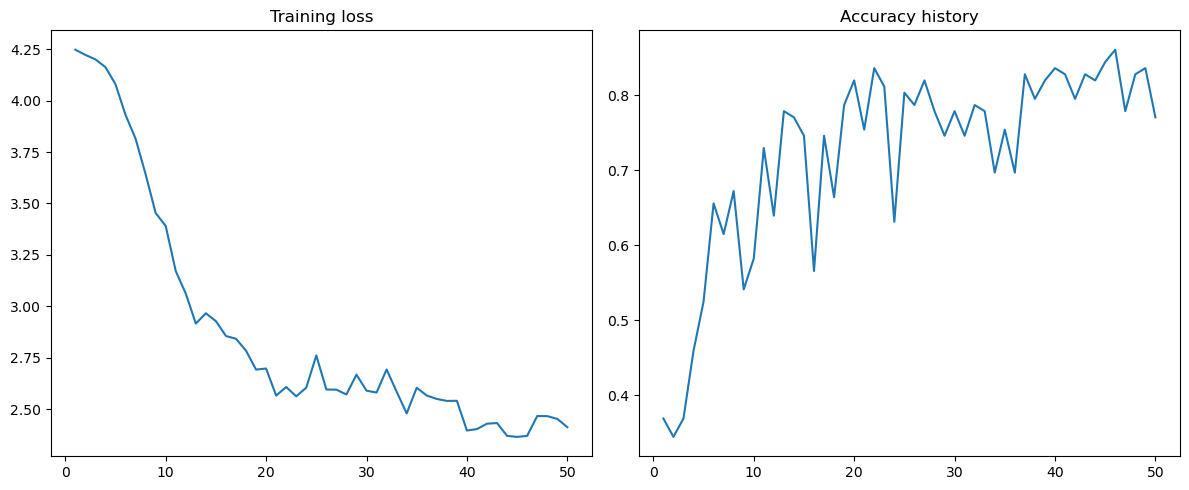

In [48]:
import matplotlib.pyplot as plt

epochs = list(range(1, EPOCHS + 1))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define the labels and data for the subplots
subplot_data = [
    {"ax": axes[0], "data": history, "title": "Training loss"},
    {"ax": axes[1], "data": acc, "title": "Accuracy history"},
]

for subplot in subplot_data:
    ax = subplot["ax"]
    data = subplot["data"]
    title = subplot["title"]

    ax.plot(epochs, data)
    ax.set_title(title)

plt.tight_layout()
plt.show()